# Assignment 4 - dimensionality reduction

## Wang Yuli 3035028946

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [6]:
import numpy as np
import pandas as pd

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential backward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

In [9]:
%matplotlib inline

In [10]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# SFS (Sequential Feature Selection) Class
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split


class SFS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit_backward(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self
    
    def fit_forward(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        num_of_features = X_train.shape[1]
        
        # select 1st feature
        scores1 = []
        subsets1 = []
        for idx in range(0, num_of_features):
            p = [idx]
            score1 = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
            subsets1.append(p)
            scores1.append(score1)
        best1 = np.argmax(scores1)
        self.indices_ = subsets1[best1]
        self.subsets_ = [self.indices_]
        self.scores_ = [scores1[best1]]
        
        # select rest of the features
        for dim in range(1, num_of_features):
            scores = []
            subsets = []
            for idx in range(0, num_of_features):
                if idx not in self.subsets_[-1]:
                    p = self.subsets_[-1][:]
                    p.append(idx)
                    score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                    subsets.append(p)
                    scores.append(score)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            self.scores_.append(scores[best])

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

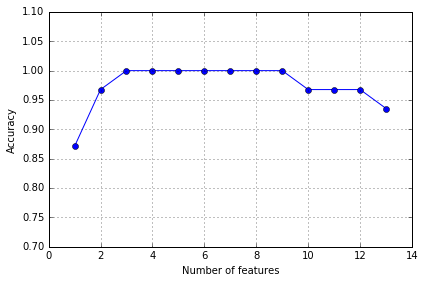

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.87096774193548387, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.93548387096774188]


[[9],
 [9, 0],
 [9, 0, 5],
 [9, 0, 5, 6],
 [9, 0, 5, 6, 10],
 [9, 0, 5, 6, 10, 7],
 [9, 0, 5, 6, 10, 7, 2],
 [9, 0, 5, 6, 10, 7, 2, 3],
 [9, 0, 5, 6, 10, 7, 2, 3, 11],
 [9, 0, 5, 6, 10, 7, 2, 3, 11, 12],
 [9, 0, 5, 6, 10, 7, 2, 3, 11, 12, 8],
 [9, 0, 5, 6, 10, 7, 2, 3, 11, 12, 8, 1],
 [9, 0, 5, 6, 10, 7, 2, 3, 11, 12, 8, 1, 4]]

In [11]:
# select features: forward
import matplotlib as mplib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sfs = SFS(knn, k_features=1)
sfs.fit_forward(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sfs.subsets_]

plt.plot(k_feat, sfs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

if mplib.get_backend().lower() in ['agg', 'macosx']: # this modification: suppress tight_layout() warning
    plt.figure().set_tight_layout(True)
else:
    plt.tight_layout()

# plt.savefig('./sbs.png', dpi=300)
plt.show()

print(k_feat)
print(sfs.scores_)
sfs.subsets_

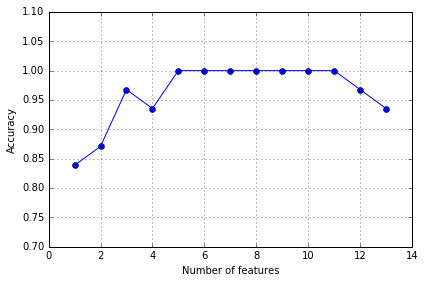

[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0.93548387096774188, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93548387096774188, 0.967741935483871, 0.87096774193548387, 0.83870967741935487]


[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 6, 7, 8, 10, 12),
 (0, 1, 2, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 10, 12),
 (0, 1, 3, 10, 12),
 (0, 1, 10, 12),
 (0, 1, 10),
 (0, 10),
 (0,)]

In [12]:
# select features: backward
import matplotlib as mplib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sfs = SFS(knn, k_features=1)
sfs.fit_backward(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sfs.subsets_]

plt.plot(k_feat, sfs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

if mplib.get_backend().lower() in ['agg', 'macosx']: # this modification: suppress tight_layout() warning
    plt.figure().set_tight_layout(True)
else:
    plt.tight_layout()

# plt.savefig('./sbs.png', dpi=300)
plt.show()

print(k_feat)
print(sfs.scores_)
sfs.subsets_


## <font color = 'purple'>Observation</font>

#### Plot: accuract vs number of features selected

The 2 plots are different but quite similar. The patterns are axial symmetric corresponding to axis: number-of-features=7. More specifically, overal accuracy increase/decrease pattern:
* optimal: forward -> interval [3,9]; backward -> interval [5,11]
* forward increase -> interval [1,3]; backward decrease ->interval [11,13]
* forward decrease -> interval [9,13]; backward increase ->interval [1,5]

#### Optimal number of features

The 2 algorithms result in differenrent optimal results. The choices are symmetric to number-of-features=7 axis
* forward selection: 3,4,5,6,7,8,9 are optimal
* backward selection: 5,6,7,8,9,10,11 are optimal

#### Optimal features selected

The 2 algorithms result in different optimal subsets as shown in the printed results of the code blocks above.

#### Accuracy scores & selected features
* accuracy scores for selecting 12 and 13 features in the 2 methods are the same respectively, while those for other number of features are different.
* The corresponding subsets for 12 and 13 are also the same, while those for other choices are different

## <font color = 'purple'>My understanding</font>

Conceptual-wise, the above 2 methods should have different plots but with symmetric pattern. 

The actual optimal method should be running through all combinations of selecting k features out of n features. Selecting k-th elements to add/delete in the subset based on assumed best performed subsets of (k-1)/(k+1) features, won't necessarily result in the best performed subsets of k features. But the selection method is still close to optimal. The reason why we use the semi-optimal methods is only to improve performance in computation.

Since the 2 algorithms goes from different directions, they are using different assumptions symmetrically Hence the semmetric pattern is explained. The scores are also expected to be different since both assumptions are just semi-optimal and not the same.


# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

## Answer

In [13]:
%matplotlib inline

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.

In [14]:
# plot regions function
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

## My data set

In [15]:
# generate data set
import random
N = 40

X = np.zeros((N*3,2))
X[0:40,0]=np.random.random([N])*4
X[40:80,0]=np.random.random([N])*3+3
X[80:120,0] = np.random.random([N])*5+3

for i in range (0,80):
    X[i,1] = 6-X[i,0]*5 + random.uniform(0,1)*5
#X[0:40,1]=np.random.random([N])
#X[40:80,1]=np.random.random([N])*4

for i in range (80, 120):
    X[i,1] = X[i,0] + 6 + random.uniform(0,1)*5
#X[80:120,1] = np.random.random([N])*5+5

y = np.zeros(N*3)
y[80:120]=1


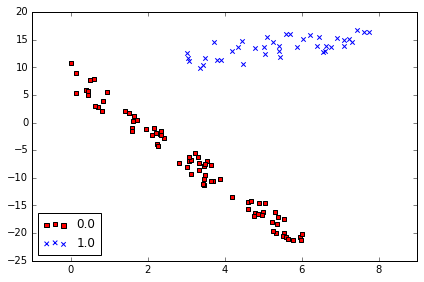

In [16]:
# plot data set
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X[y == l, 0], 
                X[y == l, 1], 
                c=c, label=l, marker=m)
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

In [17]:
# preprocessing
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=1)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

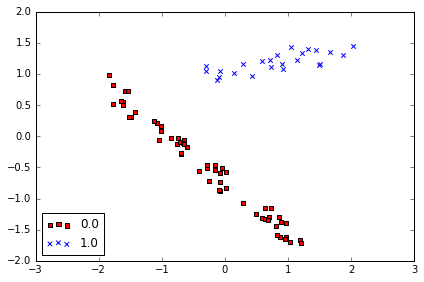

In [18]:
# plot training data set
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_std[y_train == l, 0], 
                X_train_std[y_train == l, 1], 
                c=c, label=l, marker=m)
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()


## Plot with PCA

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca.explained_variance_ratio_

array([ 0.54795677])

In [44]:
pca.components_

array([[ 0.70710678, -0.70710678]])

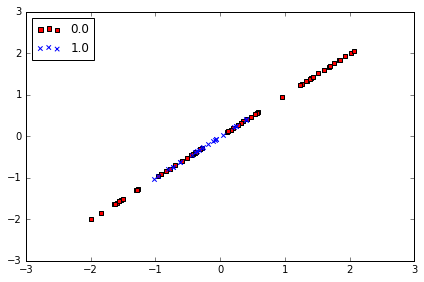

In [43]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l], 
                X_train_pca[y_train == l], 
                c=c, label=l, marker=m)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## Plot with LDA

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
lda.explained_variance_ratio_

array([ 1.])

In [45]:
lda.coef_

array([[ 13.94734479,  19.17419659]])

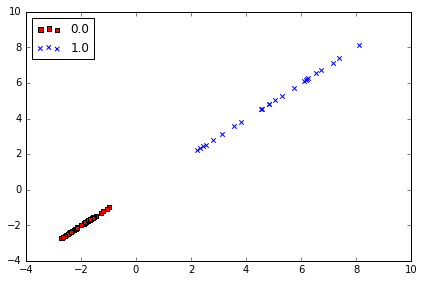

In [36]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l], 
                X_train_lda[y_train == l], 
                c=c, label=l, marker=m)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## <font color = 'purple'>Conclusion and explaination</font>

#### Foundamental difference between PCA & LDA
* PCA try to spread the dataset with maximized variance, without looking at the lables. Therefore, it only cares how all the input data set is distributed, and tries to project them so that the data spread all over the space
* LDA considers lables, trying to seperate different labels as much as possible and also squeeze the data within same class.

Therefore, if all classes of data's features, 
1. when plotted, never overlaps along all certain directions
2. any/all of the data is distributed sparse along a direction and dense along another direction

Then PCA and LDA should perform very differently in terms of projection

More specifically, we can know: if there are 1 or more features that are really redundant to our objective but with high variance, PCA and LDA would perform differently.

#### Idea to construct my data set

As shown in the very first plot, what I did is 
1. make two classes of data that don't overlap with each other in both x1 & x2 dimensions
2. class-0 is distributed relatively sparse corresponding to the x2 axis, more like around a line with slope = -0.2; class-1 is dense and approximately placed in x2 range (10,15), x1 range (4,8)

#### Observing results (n_components=1)
vectors for:
* PCA: array([[ 0.70710678, -0.70710678]])
* LDA: array([[ 13.94734479,  19.17419659]])

* Since PCA tries to spread the data as much as possible, it use a vector (not along any dimension) to project the data. From observation, it is in same direction (1, -1), which spread the unlabeled data as much as possible 
* Since LDA tries to partition 2 lables as much as possible, obviously, it uses the vector above to seperate the data as much as possible. 

The two methods produce very different plot as shown above, LDA actually perform better.
 
